Created By Kayvan Karim <br>
Based on Daniel Kienitz tutorial and https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

# Setup

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import cv2
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# MNIST

The `sklearn.datasets` package is able to download datasets from the repository using the function `sklearn.datasets.fetch_openml`.

In [8]:
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [11]:
X[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

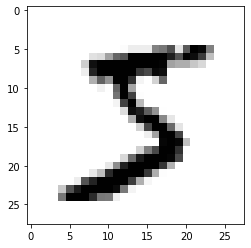

In [12]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.show()

In [13]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [14]:
y = y.astype(np.uint8)

In [15]:
y[0]

5

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [17]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

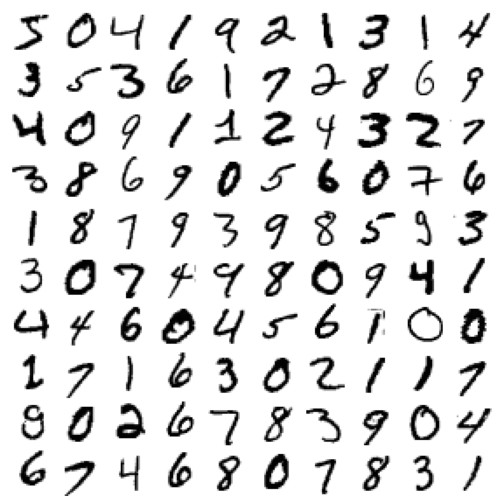

In [18]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

# Normalise the data

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [20]:
X_train[0].shape

(784,)

In [21]:
x_train = X_train.astype('float') / 255
x_test = X_test.astype('float') / 255

In [22]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

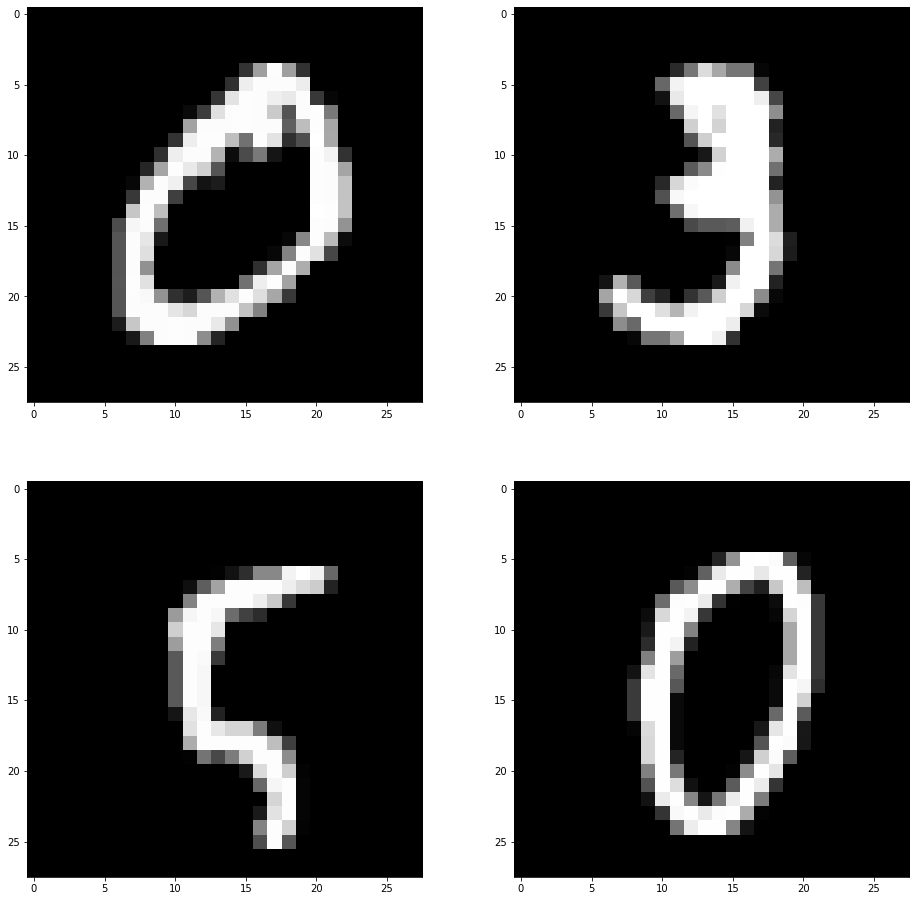

In [23]:
f, axarr = plt.subplots(2,2,figsize=(16, 16))

axarr[0,0].imshow(x_train[1].reshape(28, 28),cmap='gist_gray')
axarr[0,1].imshow(x_train[10].reshape(28, 28),cmap='gist_gray')
axarr[1,0].imshow(x_train[100].reshape(28, 28),cmap='gist_gray')
axarr[1,1].imshow(x_train[1000].reshape(28, 28),cmap='gist_gray')

In [24]:
print(y_train[1])
print(y_train[10])
print(y_train[100])
print(y_train[1000])

0
3
5
0


# Feature Reduction by Downsampling
To downsample, we can use ```cv2.resize``` <br>
If we use the vector version of the images, we will get a line. so we should reshape the images and then use resize. 

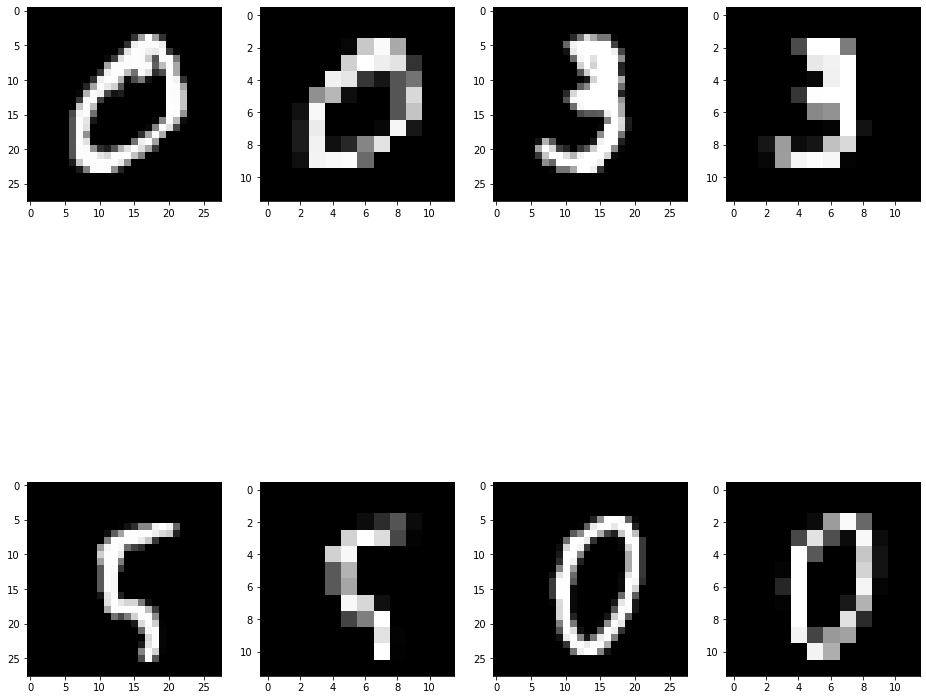

In [25]:
f, axarr = plt.subplots(2,4,figsize=(16, 16))
axarr[0,0].imshow(x_train[1].reshape(28,28),cmap='gist_gray')
axarr[0,1].imshow(cv2.resize(x_train[1].reshape(28,28),dsize=(12, 12)),cmap='gist_gray')
 
axarr[0,2].imshow(x_train[10].reshape(28,28),cmap='gist_gray')
axarr[0,3].imshow(cv2.resize(x_train[10].reshape(28,28),dsize=(12, 12)),cmap='gist_gray')

axarr[1,0].imshow(x_train[100].reshape(28,28),cmap='gist_gray')
axarr[1,1].imshow(cv2.resize(x_train[100].reshape(28,28),dsize=(12, 12)),cmap='gist_gray')

axarr[1,2].imshow(x_train[1000].reshape(28,28),cmap='gist_gray')
axarr[1,3].imshow(cv2.resize(x_train[1000].reshape(28,28),dsize=(12, 12)),cmap='gist_gray')

## Apply resize to all the dataset
There are two options that you can apply, For loops or using libraries to apply a function over your data. 

In [26]:
x_train_sm = np.apply_along_axis(
    func1d=lambda img: cv2.resize(img.reshape(28, 28), dsize=(16, 16)),
    axis=1, arr=x_train).reshape(-1, 16*16)

In [27]:
x_train_sm.shape

(60000, 256)

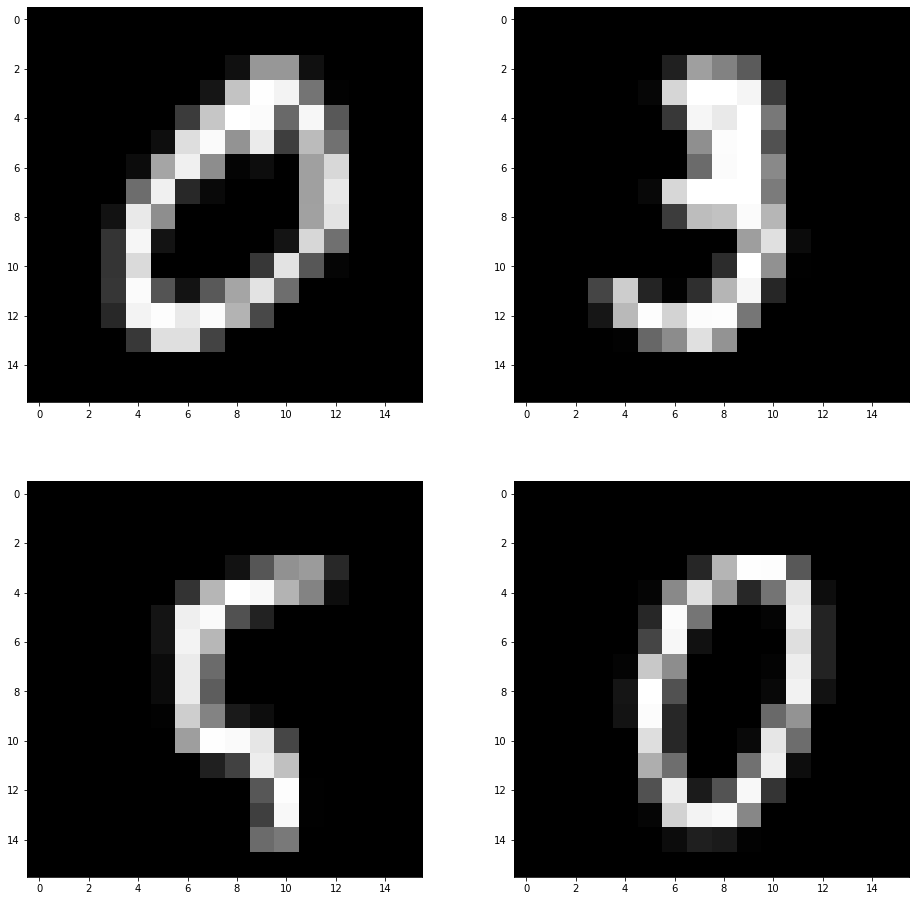

In [28]:
f, axarr = plt.subplots(2,2,figsize=(16, 16))
axarr[0,0].imshow(x_train_sm[1].reshape(16,16),cmap='gist_gray')
axarr[0,1].imshow(x_train_sm[10].reshape(16,16),cmap='gist_gray')
axarr[1,0].imshow(x_train_sm[100].reshape(16,16),cmap='gist_gray')
axarr[1,1].imshow(x_train_sm[1000].reshape(16,16),cmap='gist_gray')

# Binary classifier

In this section, we use the original dataset and not the downsample version

In [29]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's find if a digit is 5 or not 5

In [30]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

## Stochastic Gradient Descent (SGD)

In [31]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [32]:
sgd_clf.predict([some_digit]) #The classifier guesses that this image represents a 5 (True). 

array([ True])

# Performance Measures 

Measuring Accuracy Using **Cross-Validation**

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

 A classifier that just classifies every single image in the “not-5” class

In [34]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's check the accuracy 

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The reason behind this heigh accuracy is only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. <br/><br/>
This is the reason **accuracy is generally not the preferred performance measure** for classifiers

# Confusion Matrix

<div>
<img src="https://miro.medium.com/max/1051/1*fxiTNIgOyvAombPJx5KGeA.png" alt="Confusion Matrix" style="width: 400px;"/>
</div

In [36]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [38]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

$\large{precision = \frac{TP}{TP+FP}}$

In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [40]:
3530 / (3530 + 687)

0.8370879772350012

$\large{recall = \frac{TP}{TP+FN}}$

In [41]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [42]:
3530 / (3530 + 1891)

0.6511713705958311

$\large{ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times\frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}} }$

In [43]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [44]:
3530 / (3530 + (1891 + 687) / 2)

0.7325171197343847

## Precision/Recall Trade-off

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [46]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [47]:
y_some_digit_pred

array([ True])

In [48]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

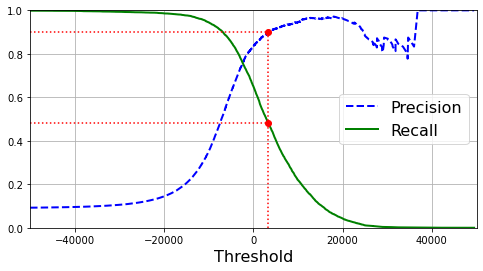

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [52]:
(y_train_pred == (y_scores > 0)).all()

True

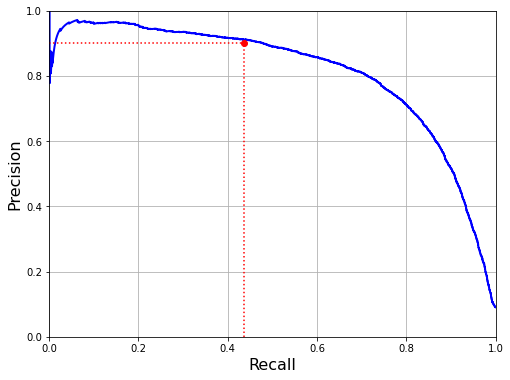

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [54]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [55]:
threshold_90_precision

3370.0194991439557

In [56]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [57]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [58]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# The ROC curves

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores, drop_intermediate=False)

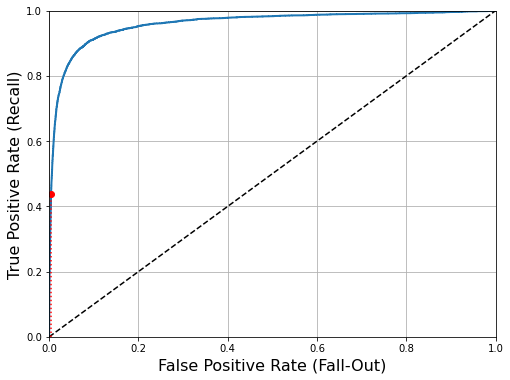

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [61]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [63]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

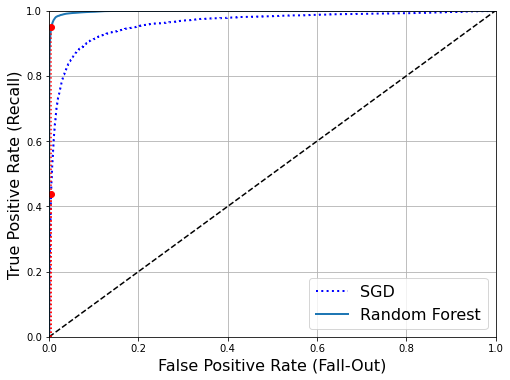

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [66]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [67]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591